In [302]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import statsmodels.api as sm

from numpy import asarray
from sklearn.preprocessing import MinMaxScaler

from dateutil.relativedelta import relativedelta

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
data = pd.read_csv("./data/kc_house_data.csv")

# Using My Model With Custom Data

### Load Models, Scalers, And Base Data

In [303]:
# Load Data From Inital model and scaler
with open('regression_Initial_Model_sk.pickle', 'rb') as file:
    data_Model1_sk = pickle.load(file)
    
with open('scaler_1.pickle', 'rb') as file:
    scaler_1 = pickle.load(file)    

with open('data_Target_Homes_Not_Scaled_WithDummies.pickle', 'rb') as file:
    data_Target_Homes_Not_Scaled_WithDummies = pickle.load(file)    
    
with open('data_Target_Homes.pickle', 'rb') as file:
    data_Target_Homes = pickle.load(file)    


In [304]:
# Load Data From Second model and scaler
with open('regression_Second_Model_sk.pickle', 'rb') as file:
    data_Model2_sk = pickle.load(file)
    
with open('scaler_2.pickle', 'rb') as file:
    scaler_2 = pickle.load(file)    

with open('data_with_Hot_Dist_POints_WithDummies.pickle', 'rb') as file:
    data_with_Hot_Dist_POints_WithDummies = pickle.load(file)
    
    
with open('regression_Data_Second_Model.pickle', 'rb') as file:
    data_Model2 = pickle.load(file)

In [305]:
# Load Data From Third model and scaler
with open('regression_Third_Model_sk.pickle', 'rb') as file:
    data_Model3_sk = pickle.load(file)
    
with open('scaler_3.pickle', 'rb') as file:
    scaler_2 = pickle.load(file)    

with open('df_data_with_Appraisals.pickle', 'rb') as file:
    df_data_with_Appraisals = pickle.load(file)
    
    
with open('regression_Data_Third_Model.pickle', 'rb') as file:
    data_Model3 = pickle.load(file)

### Misc Functions

In [306]:
#Create the columns to scale, ensure alignment, need different names given different dataframes and prefixes for each type of the same col
colsToScale = ['bedrooms', 'bathrooms','sqft_living','sqft_lot','sqft_basement','sqft_living15', 'sqft_lot15', 'floors',
               'sqft_above','AgeOfHome','ttl_rooms']

colsToScale_with_a = list(["a_" + e for e in colsToScale])
colsToScale_with_sc = list(["sc_" + e for e in colsToScale])
colsToScale_with_n_sc  = list(["n_sc_" + e for e in colsToScale])


In [307]:
#Scale the data from initial model as this is the only scaled data I am going to be changing to demonstrate 
# changes in features impact on model
#Unscaled numbers

data_Target_Homes_colsToScale = data_Target_Homes_Not_Scaled_WithDummies[colsToScale] 

Scaled_Data_1 = scaler_1.transform(data_Target_Homes_colsToScale)
df_Scaled_Data_1 = pd.DataFrame(data=Scaled_Data_1, columns=colsToScale_with_sc)

#Combined scaled values with original values
data_Target_Homes_Not_Scaled_WithDummies = data_Target_Homes_Not_Scaled_WithDummies.reset_index(drop=True)
data_Target_Homes_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, df_Scaled_Data_1], axis=1)


In [308]:
#update value of target column using unscaled units
def Calculate_New_Unscaled_Value_For_TargetCol(TargetColumn, deltaInValue, TargetDataFrame, id=0):
    
    
#     print(f'Inside function Target column {TargetColumn}')
# #     print(f'our of dataframe {TargetDataFrame["a_sqft_above"]}')
    
    #if continueous/ squart foot above 
    if (TargetColumn == "sqft_above") or (TargetColumn == "a_sqft_above"):
        Target_UnscaledValue_ForTargetCol = TargetDataFrame[TargetColumn].values
#         print(type)
        UpdatedValue_ForTargetCol = (Target_UnscaledValue_ForTargetCol + deltaInValue)
#         print(f' inside calculate unscaled targetcol, original = {Target_UnscaledValue_ForTargetCol}')
#         print(f' inside calculate unscaled targetcol, delta = {deltaInValue}')
#         print(f' inside calculate unscaled targetcol, new value = {UpdatedValue_ForTargetCol}')
        
    if (TargetColumn[:5] == "grade") or (TargetColumn[:7] == "a_grade"):
        Target_UnscaledValue_ForTargetCol = TargetDataFrame[TargetColumn].values
        UpdatedValue_ForTargetCol = deltaInValue
        
    return UpdatedValue_ForTargetCol

In [309]:
#Get and insert the average value for each feature for easy retravial when adding values to demonstrate regression
def resetAverages():
    df_Averages = pd.DataFrame()
    df_Averages['a_bedrooms'] = [data_Target_Homes_Not_Scaled_WithDummies['bedrooms'].mean()]
    df_Averages['a_bathrooms'] = [data_Target_Homes_Not_Scaled_WithDummies['bathrooms'].mean()]
    df_Averages['a_sqft_living'] = [data_Target_Homes_Not_Scaled_WithDummies['sqft_living'].mean()]
    df_Averages['a_sqft_lot'] = [data_Target_Homes_Not_Scaled_WithDummies['sqft_lot'].mean()]
    df_Averages['a_sqft_basement'] = [data_Target_Homes_Not_Scaled_WithDummies['sqft_basement'].mean()]
    df_Averages['a_sqft_living15'] = [data_Target_Homes_Not_Scaled_WithDummies['sqft_living15'].mean()]
    df_Averages['a_sqft_lot15'] = [data_Target_Homes_Not_Scaled_WithDummies['sqft_lot15'].mean()]
    df_Averages['a_floors'] = [data_Target_Homes_Not_Scaled_WithDummies['floors'].mean()]
    df_Averages['a_sqft_above'] = [data_Target_Homes_Not_Scaled_WithDummies['sqft_above'].mean()]
    df_Averages['a_AgeOfHome'] = [data_Target_Homes_Not_Scaled_WithDummies['AgeOfHome'].mean()]
    df_Averages['a_ttl_rooms'] = [data_Target_Homes_Not_Scaled_WithDummies['ttl_rooms'].mean()]
    df_Averages['a_waterfront_1'] = [0]
    df_Averages['a_view_1'] = [0]
    df_Averages['a_view_2'] = [0]
    df_Averages['a_view_3'] = [0]
    df_Averages['a_view_4'] = [0]
    df_Averages['a_condition_4'] = [0]
    df_Averages['a_condition_5'] = [0]
    df_Averages['a_grade_6'] = [0]
    df_Averages['a_grade_8'] = [1]
    df_Averages['a_grade_9'] = [0]
    df_Averages['a_grade_10'] = [0]
    df_Averages['a_grade_11'] = [0]
    df_Averages['a_ZipFirst3_981'] =[0]
    df_Averages['a_sls_mnth_2'] = [0]
    df_Averages['a_sls_mnth_3'] = [0]
    df_Averages['a_sls_mnth_4'] = [0]
    df_Averages['a_sls_mnth_5'] = [1]
    df_Averages['a_sls_mnth_6'] = [0]
    df_Averages['a_sls_mnth_7'] = [0]
    df_Averages['a_sls_mnth_8'] = [0]
    df_Averages['a_sls_mnth_9'] = [0]
    df_Averages['a_sls_mnth_10'] = [0]
    df_Averages['a_sls_mnth_11'] = [0]
    df_Averages['a_sls_mnth_12'] = [0]
    df_Averages['a_If_renovated_1'] = [0]
    
    # caluculate the averages after scaling the dataframe
    df_Averages['a_sc_bedrooms'] = data_Target_Homes_Scaled_WithDummies['sc_bedrooms'].mean()
    df_Averages['a_sc_bathrooms'] = data_Target_Homes_Scaled_WithDummies['sc_bathrooms'].mean()
    df_Averages['a_sc_sqft_living'] =data_Target_Homes_Scaled_WithDummies['sc_sqft_living'].mean()
    df_Averages['a_sc_sqft_lot'] = data_Target_Homes_Scaled_WithDummies['sc_sqft_lot'].mean()
    df_Averages['a_sc_sqft_basement'] = data_Target_Homes_Scaled_WithDummies['sc_sqft_basement'].mean()
    df_Averages['a_sc_sqft_living15'] = data_Target_Homes_Scaled_WithDummies['sc_sqft_living15'].mean()
    df_Averages['a_sc_sqft_lot15'] = data_Target_Homes_Scaled_WithDummies['sc_sqft_lot15'].mean()
    df_Averages['a_sc_floors'] = data_Target_Homes_Scaled_WithDummies['sc_floors'].mean()
    df_Averages['a_sc_sqft_above'] = data_Target_Homes_Scaled_WithDummies['sc_sqft_above'].mean()
    df_Averages['a_sc_AgeOfHome'] = data_Target_Homes_Scaled_WithDummies['sc_AgeOfHome'].mean()
    df_Averages['a_sc_ttl_rooms'] = data_Target_Homes_Scaled_WithDummies['sc_ttl_rooms'].mean()
    
    #newly added averages from datamodel 2
    df_Averages['a_Sch_d_Top15'] = 0
    df_Averages['a_Sch_d_Top30'] = 0
    df_Averages['a_Sch_d_Top60'] = 1
#     df_Averages['a_Under10'] = 10
#     df_Averages['a_Over20'] = 10
    df_Averages['a_sc_Under10'] = data_Model2["Under10"].mean()
    df_Averages['a_sc_Over20'] = data_Model2["Over20"].mean()
    
    #newly added averages from datamodel 3
#     df_Averages['YrRollingAppraisal'] 
#     df_Averages['AppraisedLandValue']
#     df_Averages['AppraisedImpsValue']
#     df_Averages['LandToHouseCheck']
#     df_Averages['InflationSinceLastAppraisal']
#     df_Averages['InflationSinceLastAppraisal_abs']
#     df_Averages['AppraisedTotal']
    df_Averages['a_sc_AssesorAppraisals_x'] = df_data_with_Appraisals['AssesorAppraisals_x'].mean()
    return df_Averages


In [310]:
df_Averages

,a_bedrooms,a_bathrooms,a_sqft_living,a_sqft_lot,a_sqft_basement,a_sqft_living15,a_sqft_lot15,a_floors,a_sqft_above,a_AgeOfHome,a_ttl_rooms,a_waterfront_1,a_view_1,a_view_2,a_view_3,a_view_4,a_condition_4,a_condition_5,a_grade_6,a_grade_8,a_grade_9,a_grade_10,a_grade_11,a_ZipFirst3_981,a_sls_mnth_2,...,a_sls_mnth_6,a_sls_mnth_7,a_sls_mnth_8,a_sls_mnth_9,a_sls_mnth_10,a_sls_mnth_11,a_sls_mnth_12,a_If_renovated_1,a_sc_bedrooms,a_sc_bathrooms,a_sc_sqft_living,a_sc_sqft_lot,a_sc_sqft_basement,a_sc_sqft_living15,a_sc_sqft_lot15,a_sc_floors,a_sc_sqft_above,a_sc_AgeOfHome,a_sc_ttl_rooms,a_Sch_d_Top15,a_Sch_d_Top30,a_Sch_d_Top60,a_sc_Under10,a_sc_Over20,a_sc_AssesorAppraisals_x
0,3.555344,2.082061,2099.081788,6932.400218,716.332879,1851.636314,7027.358779,1.16753,1382.748909,60.865867,7.689477,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.319418,0.270515,0.342204,0.488733,0.330107,0.346178,0.213695,0.083765,0.22911,0.48579,0.169354,0,0,1,0.37204,0.068402,0.180597


### Using Model To Predict Prices with Custom Values

In [311]:
#Scenario 1, using Model 1, Physical Features Only

df_Already_Scaled_Data_From_Model_2_And3 = pd.DataFrame()

#Start by getting The "Avearge" home 
df_Averages = resetAverages()

ListOfTargets = ["sqft_above"]
ListOfdeltas = [0]

# ListOfTargets = ["grade_10"]
# ListOfdeltas = [1]

# ListOfTargets = ["sqft_above", "grade_8"]
# ListOfdeltas = [0,1]

ChangedFeatures = list(zip(ListOfTargets, ListOfdeltas))

#enter In targeted home, or enter 0 to get the average change
# parcelID = 2487200875
parcelID = 0

if parcelID ==0:
    #we are calculating for an avearge
    df_target_data_to_scale = df_Averages
    
    for targetCol, delta in ChangedFeatures:
        TargetColumn = "a_" + targetCol
        NewValue = Calculate_New_Unscaled_Value_For_TargetCol(TargetColumn,delta,df_target_data_to_scale,parcelID)
#         print(type(NewValue))
        df_target_data_to_scale[TargetColumn] = NewValue[0]
        print(df_target_data_to_scale[TargetColumn])
        
#         print(NewValue)
        #if changing a dummy variable need to reset all dummies along with updating the new dummy column
        
        if (TargetColumn[:7] == "a_grade"):
            df_target_data_to_scale["a_grade_11"] = 0
            df_target_data_to_scale["grade_10"] = 0
            df_target_data_to_scale["a_grade_9"] = 0
            df_target_data_to_scale["a_grade_8"] = 0
            df_target_data_to_scale["a_grade_6"] = 0
            df_target_data_to_scale[TargetColumn] = 1
            
    #Need to changed colstoscale given target dataframe has cols with "a_" 
    colsToScale = colsToScale_with_a
    
    colsToFeed_In_to_Predict = ['a_sc_AssesorAppraisals_x', 'a_Sch_d_Top15', 'a_Sch_d_Top30', 'a_Sch_d_Top60',
       'a_sc_Under10', 'a_sc_Over20', 'a_view_1', 'a_view_2', 'a_view_3', 'a_view_4',
       'a_condition_4', 'a_condition_5', 'a_grade_6', 'a_grade_8', 'a_grade_9',
       'a_grade_10', 'a_sls_mnth_2', 'a_sls_mnth_3', 'a_sls_mnth_4', 'a_sls_mnth_5',
       'a_sls_mnth_6', 'a_sls_mnth_7', 'a_sls_mnth_8', 'a_sls_mnth_9', 'a_sls_mnth_10',
       'a_sls_mnth_11', 'a_sls_mnth_12', 'a_If_renovated_1', 'a_sc_sqft_lot',
       'a_sc_sqft_basement', 'n_sc_sqft_above']


else:
    # we are calculating data using a real home
    df_target_data_to_scale = data_Target_Homes_Not_Scaled_WithDummies.loc[data_Target_Homes_Not_Scaled_WithDummies['id']==parcelID]
    df_target_data_to_scale = df_target_data_to_scale[colsToScale]
    df_Already_Scaled_Data_From_Model_2_And3 = df_data_with_Appraisals.loc[df_data_with_Appraisals['id']==parcelID]
    
    for targetCol, delta in ChangedFeatures:
        TargetColumn = targetCol
        NewValue = Calculate_New_Unscaled_Value_For_TargetCol(TargetColumn,delta,df_target_data_to_scale,parcelID)
        df_target_data_to_scale[TargetColumn] = NewValue
        
        if (TargetColumn[:5] == "grade"):
            df_target_data_to_scale["grade_11"] = 0
            df_target_data_to_scale["grade_10"] = 0
            df_target_data_to_scale["grade_9"] = 0
            df_target_data_to_scale["grade_8"] = 0
            df_target_data_to_scale["grade_6"] = 0
#             df_target_data_to_scale[TargetColumn] = 1

    colsToFeed_In_to_Predict = ['AssesorAppraisals_x', 'Sch_d_Top15', 'Sch_d_Top30', 'Sch_d_Top60',
       'Under10', 'Over20', 'view_1', 'view_2', 'view_3', 'view_4',
       'condition_4', 'condition_5', 'grade_6', 'grade_8', 'grade_9',
       'grade_10', 'sls_mnth_2', 'sls_mnth_3', 'sls_mnth_4', 'sls_mnth_5',
       'sls_mnth_6', 'sls_mnth_7', 'sls_mnth_8', 'sls_mnth_9', 'sls_mnth_10',
       'sls_mnth_11', 'sls_mnth_12', 'If_renovated_1', 'n_sc_sqft_lot',
       'n_sc_sqft_basement', 'n_sc_sqft_above']

#Scale and create dataframe of scaled values
Scaled_Data_1 = scaler_1.transform(df_target_data_to_scale[colsToScale])
df_Scaled_Data_1 = pd.DataFrame(data=Scaled_Data_1, columns=colsToScale_with_n_sc)

#combined scaled values with other non scaled features needed to feed into predcit
df_target_data_to_scale = df_target_data_to_scale.reset_index(drop=True)
data_TargetHomes_With_Updated_TargetColumn = pd.concat([df_target_data_to_scale, df_Scaled_Data_1], axis=1)
data_TargetHomes_With_Updated_TargetColumn = data_TargetHomes_With_Updated_TargetColumn.reset_index(drop=True)

data_TargetHomes_With_Updated_TargetColumn1 = pd.concat([data_TargetHomes_With_Updated_TargetColumn, df_Already_Scaled_Data_From_Model_2_And3], axis=1)


#Get the columns needed and order required to feed into predict
df_Home_To_Predict_No_ID = data_TargetHomes_With_Updated_TargetColumn1 [colsToFeed_In_to_Predict]

y_hat_average = data_Model3_sk.predict(df_Home_To_Predict_No_ID)
print(y_hat_average)
print(np.exp(y_hat_average))


0    1382.748909
Name: a_sqft_above, dtype: float64
[12.86217805]
[385454.34936617]


In [280]:
366606-362807

3799

In [312]:
385454-362807


22647

In [281]:
df_Scaled_Data_1

,n_sc_bedrooms,n_sc_bathrooms,n_sc_sqft_living,n_sc_sqft_lot,n_sc_sqft_basement,n_sc_sqft_living15,n_sc_sqft_lot15,n_sc_floors,n_sc_sqft_above,n_sc_AgeOfHome,n_sc_ttl_rooms
0,0.319418,0.270515,0.342204,0.488733,0.330107,0.346178,0.213695,0.083765,0.262667,0.48579,0.169354


In [282]:
test = df_Averages["a_sqft_above"]
test

0    1482.748909
Name: a_sqft_above, dtype: float64

# Visuals for Presentation

In [283]:
data_Target_Homes_Not_Scaled_WithDummies

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3_int,salesyear,ttl_rooms,log_price,waterfront_1,ZipFirst3_981,view_1,view_2,view_3,view_4,condition_3,condition_4,condition_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,sls_mnth_2,sls_mnth_3,sls_mnth_4,sls_mnth_5,sls_mnth_6,sls_mnth_7,sls_mnth_8,sls_mnth_9,sls_mnth_10,sls_mnth_11,sls_mnth_12,If_renovated_1
0,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,69,981,2014,6.75,13.195614,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,55,981,2014,12.00,13.311329,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1736800520,4/3/2015,662500.0,3,2.50,3560,9796,1.0,1860,1700.0,1965,0.0,98007,47.6007,-122.145,2210,8925,55,980,2015,7.50,13.403776,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,9212900260,5/27/2014,468000.0,2,1.00,1160,6000,1.0,860,300.0,1942,0.0,98115,47.6900,-122.292,1330,6000,78,981,2014,2.00,13.056224,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,9297300055,1/24/2015,650000.0,4,3.00,2950,5000,2.0,1980,970.0,1979,0.0,98126,47.5714,-122.375,2140,4000,41,981,2015,12.00,13.384728,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3663,6891100090,10/14/2014,850000.0,5,3.50,4200,5400,2.0,3140,1060.0,2012,0.0,98052,47.7077,-122.120,3300,5564,8,980,2014,17.50,13.652992,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3664,2487200490,6/23/2014,670000.0,3,2.50,3310,5300,2.0,2440,870.0,2008,0.0,98136,47.5178,-122.389,2140,7500,12,981,2014,7.50,13.415033,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3665,3438501862,5/13/2014,330000.0,3,2.50,1450,5008,1.0,840,610.0,2007,0.0,98106,47.5435,-122.357,2120,5019,13,981,2014,7.50,12.706848,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3666,3345700207,5/2/2015,608500.0,4,3.50,2850,5577,2.0,1950,900.0,2014,0.0,98056,47.5252,-122.192,2850,5708,6,980,2015,14.00,13.318752,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


C:\Users\rgpih\anaconda3a\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


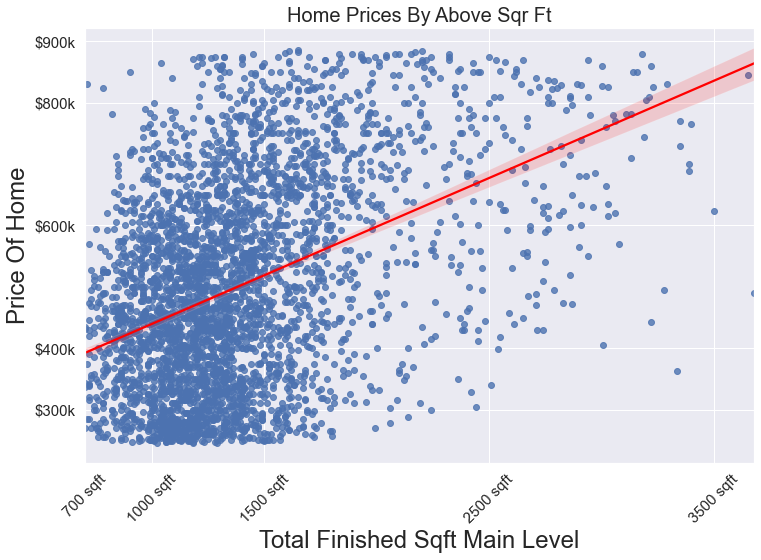

In [284]:
df = data_Target_Homes_Not_Scaled_WithDummies
sns.set_style("whitegrid")
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
plt.subplot(111)
# ax.grid(True)

# ax.grid()
# Don't allow the axis to be on top of your data
# ax.set_axisbelow(False)

# Customize the grid
ax.grid(linestyle='-', linewidth='2')

sns.regplot(df.sqft_above, df.price, line_kws={"color": "red"})

plt.title('Home Prices By Above Sqr Ft', fontsize=20)

# plt.subplots_adjust(hspace=0.5)

plt.yticks(ticks=(300000, 400000, 600000, 800000, 900000), 
           labels= ('$300k', '$400k', '$600k', '$800k','$900k'),fontsize=15 )

plt.xticks(ticks=(700, 1000, 1500, 2500, 3500), 
           labels= ('700 sqft', '1000 sqft', '1500 sqft', '2500 sqft','3500 sqft'),fontsize=15,rotation=45)

plt.xlabel("Total Finished Sqft Main Level")
plt.ylabel("Price Of Home")

plt.show()



In [285]:
data_Target_Homes.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,If_renovated,AgeOfHome,ZipFirst3,ZipFirst3_int,salesyear,sls_month,ttl_rooms,log_price
0,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,1,69,981,981,2014,12,6.75,13.195614
1,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,0,55,981,981,2014,12,12.00,13.311329
2,1736800520,4/3/2015,662500.0,3,2.50,3560,9796,1.0,0.0,0.0,3,8,1860,1700.0,1965,0.0,98007,47.6007,-122.145,2210,8925,0,55,980,980,2015,4,7.50,13.403776
3,9212900260,5/27/2014,468000.0,2,1.00,1160,6000,1.0,0.0,0.0,4,7,860,300.0,1942,0.0,98115,47.6900,-122.292,1330,6000,0,78,981,981,2014,5,2.00,13.056224
4,9297300055,1/24/2015,650000.0,4,3.00,2950,5000,2.0,0.0,3.0,3,9,1980,970.0,1979,0.0,98126,47.5714,-122.375,2140,4000,0,41,981,981,2015,1,12.00,13.384728


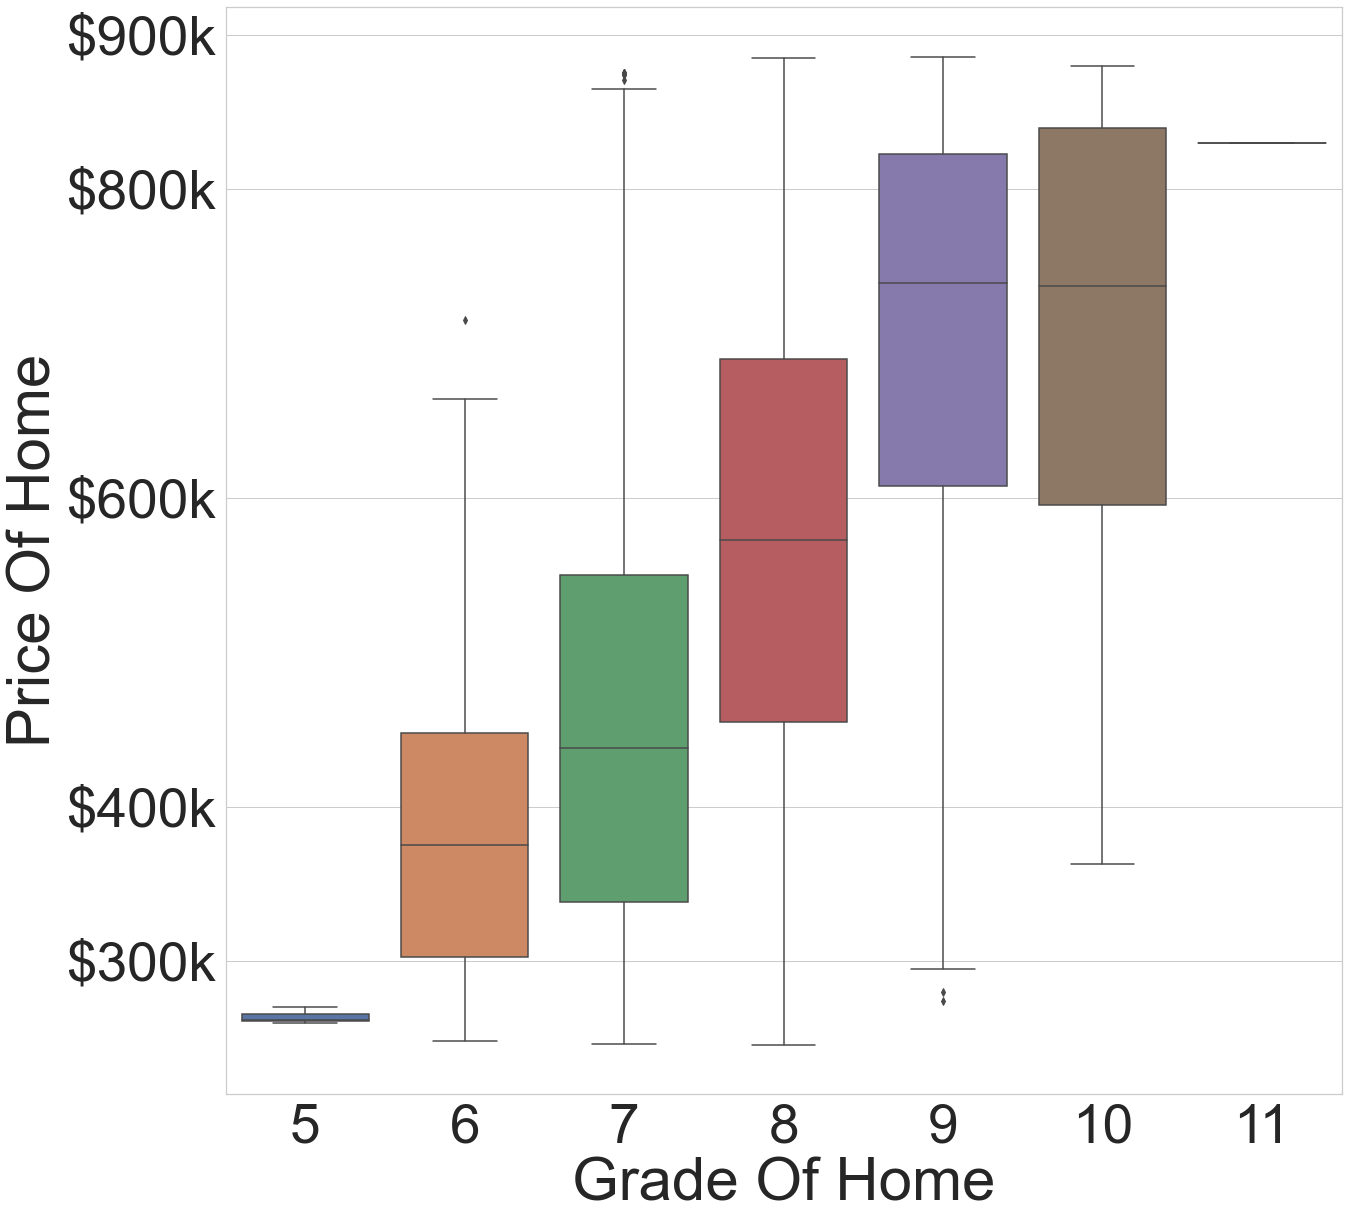

In [291]:
plt.figure(figsize=(20,20), facecolor="white")
sns.set(font_scale=5)
sns.set_style("whitegrid")
sns.boxplot(x='grade', y='price', data=data_Target_Homes);
plt.yticks(ticks=(300000, 400000, 600000, 800000, 900000), 
           labels= ('$300k', '$400k', '$600k', '$800k','$900k'))
plt.xlabel("Grade Of Home")
plt.ylabel("Price Of Home")
    
plt.show();